# Rolling Horizon Framework - Notebook 1
This notebook contains code for the initial analysis seen for the preliminary comparison of the RH strategy against the optimal policies without forecast error

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

import pickle


In [2]:


#!pip install gurobipy  # install gurobipy, if not already installed
import gurobipy as gp  # import the installed package

# Create an environment with your WLS license
params = {
"WLSACCESSID": '3c7664d9-a91c-4ed0-9b3b-b081e39c7003',
"WLSSECRET": '9689803a-3d35-439b-8270-34d60b732a6b',
"LICENSEID": 2440162,
}

env = gp.Env(params=params)

# Create the model within the Gurobi environment
model = gp.Model(env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2440162
Set parameter WLSAccessID
Set parameter WLSSecret
Academic license 2440162 - for non-commercial use only - registered to sa___@ucl.ac.uk


## Household demand

Household demand is used by one dataset that collects detailed 

                    UTC                   DE TIME    kWh  0.045  \
0  2015-10-26T11:00:00Z  2015-10-26T12:00:00+0100  0.045  0.395   
1  2015-10-26T12:00:00Z  2015-10-26T13:00:00+0100  0.395  0.865   
2  2015-10-26T13:00:00Z  2015-10-26T14:00:00+0100  0.865  1.085   
3  2015-10-26T14:00:00Z  2015-10-26T15:00:00+0100  1.085  1.325   
4  2015-10-26T15:00:00Z  2015-10-26T16:00:00+0100  1.325  1.435   

   Power Change (kWh)  
0                0.00  
1                0.35  
2                0.47  
3                0.22  
4                0.24  
Starting date: 2015-10-26 11:00:00+00:00
Ending date: 2019-05-01 22:00:00+00:00
                            UTC                   DE TIME       kWh     0.045  \
19141 2018-01-01 00:00:00+00:00  2018-01-01T01:00:00+0100  5975.186  5975.412   
19142 2018-01-01 01:00:00+00:00  2018-01-01T02:00:00+0100  5975.412  5975.591   
19143 2018-01-01 02:00:00+00:00  2018-01-01T03:00:00+0100  5975.591  5975.752   
19144 2018-01-01 03:00:00+00:00  2018-01-01T04:00

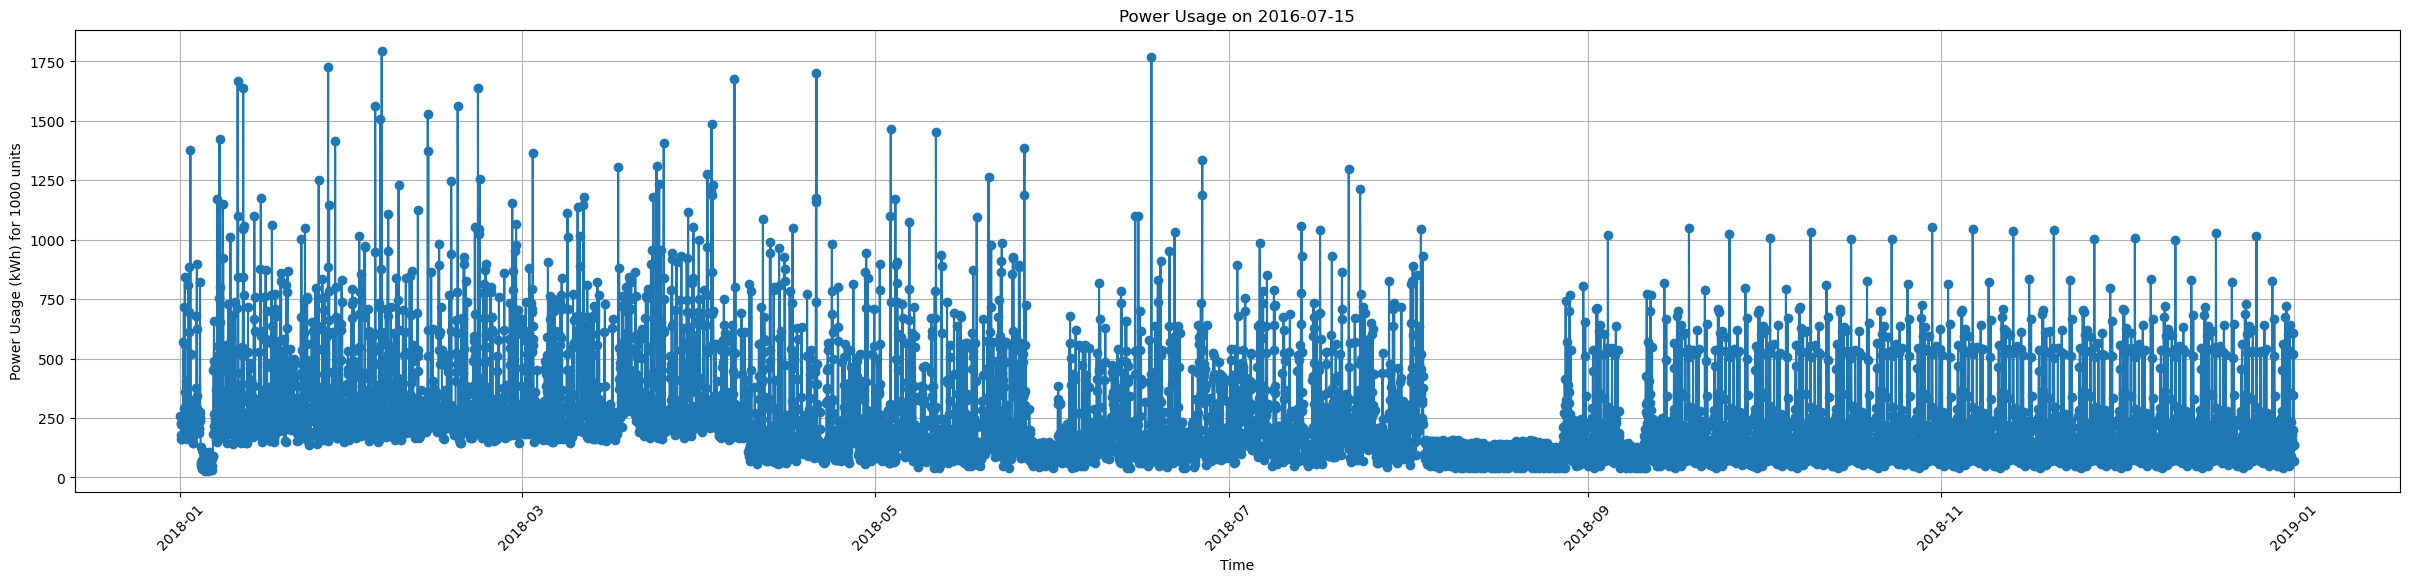

In [3]:

# Load and preprocess household demand data
df = pd.read_csv('demand.csv')
df['Power Change (kWh)'] = df['kWh'].diff().fillna(0)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
print(df.head())

# Convert UTC timestamp to datetime and select a random date for plotting
df['UTC'] = pd.to_datetime(df['UTC'])
df['Date'] = df['UTC'].dt.date
random_date = np.random.choice(df['Date'].unique())
day_data = df[df['Date'] == random_date]

# # Plot power usage for the selected date
# plt.figure(figsize=(10, 6))
# plt.plot(day_data['UTC'], day_data['Power Change (kWh)'], marker='o', linestyle='-')
# plt.title(f'Power Usage on {random_date}')
# plt.xlabel('Time')
# plt.ylabel('Power Usage (kWh)')
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.tight_layout()  # Adjusts plot parameters for better layout
# plt.show()

# Assuming 'UTC time' is the column with your dates
start_date = df['UTC'].min()
end_date = df['UTC'].max()

print(f"Starting date: {start_date}")
print(f"Ending date: {end_date}")


# Filter the DataFrame for the specified date range
filtered_df = df[(df['UTC'] >= '2018-01-01') & (df['UTC'] <= '2019-01-01')]

# Display the new DataFrame to verify the filter
print(filtered_df)


def adjust_kwh(units):
    # Multiply the 'kWh' column by the number of units
    adjusted_values = filtered_df['Power Change (kWh)'] * units
    
    # Add a 3% random error to each value
    # The random error is generated as 3% of the adjusted value multiplied by a random number between -1 and 1
    random_error = adjusted_values * 0.03 * np.random.uniform(-1, 1, size=adjusted_values.shape)
    
    # Apply the random error to the adjusted values
    final_values = adjusted_values + random_error
    
    # Return the final values as a NumPy array
    return final_values.to_numpy()

result_array = adjust_kwh(1000)

# Display the result
print(result_array)



# Plotting
plt.figure(figsize=(30, 6))
plt.plot(filtered_df['UTC'], result_array, marker='o', linestyle='-')
plt.title(f'Power Usage on {random_date}')
plt.xlabel('Time')
plt.ylabel('Power Usage (kWh) for 1000 units')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Prices

In [4]:
# Load the CSV file
file_path = '15minprices.csv'
df_prices = pd.read_csv(file_path)
# Set the font family to Times New Roman
plt.rcParams["font.family"] = "CMU Serif"
plt.rc('axes', unicode_minus=False)

df_prices['Day-ahead Price [EUR/MWh]'].fillna(method='ffill', inplace=True)
df_prices['MTU (CET/CEST)'].str.split('-').str[0].str.strip()
df_prices['Timestamp'] = pd.to_datetime(df_prices['MTU (CET/CEST)'].str.split('-').str[0].str.strip(), format="%d.%m.%Y %H:%M")

# Set the datetime as the index
df_prices.set_index('Timestamp', inplace=True)

# Resample to hourly intervals and calculate the mean
df_prices = df_prices['Day-ahead Price [EUR/MWh]'].resample('H').mean().reset_index()

# Resulting DataFrame has hourly intervals with the average price
print(df_prices.shape)

df_prices.head()




C:\Users\Sarang Sujit\AppData\Local\Temp\ipykernel_20032\436930007.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_prices['Day-ahead Price [EUR/MWh]'].fillna(method='ffill', inplace=True)


(8760, 2)


,Timestamp,Day-ahead Price [EUR/MWh]
0,2019-01-01 00:00:00,20.0025
1,2019-01-01 01:00:00,13.5400
2,2019-01-01 02:00:00,5.5925
3,2019-01-01 03:00:00,3.2000
4,2019-01-01 04:00:00,3.8975


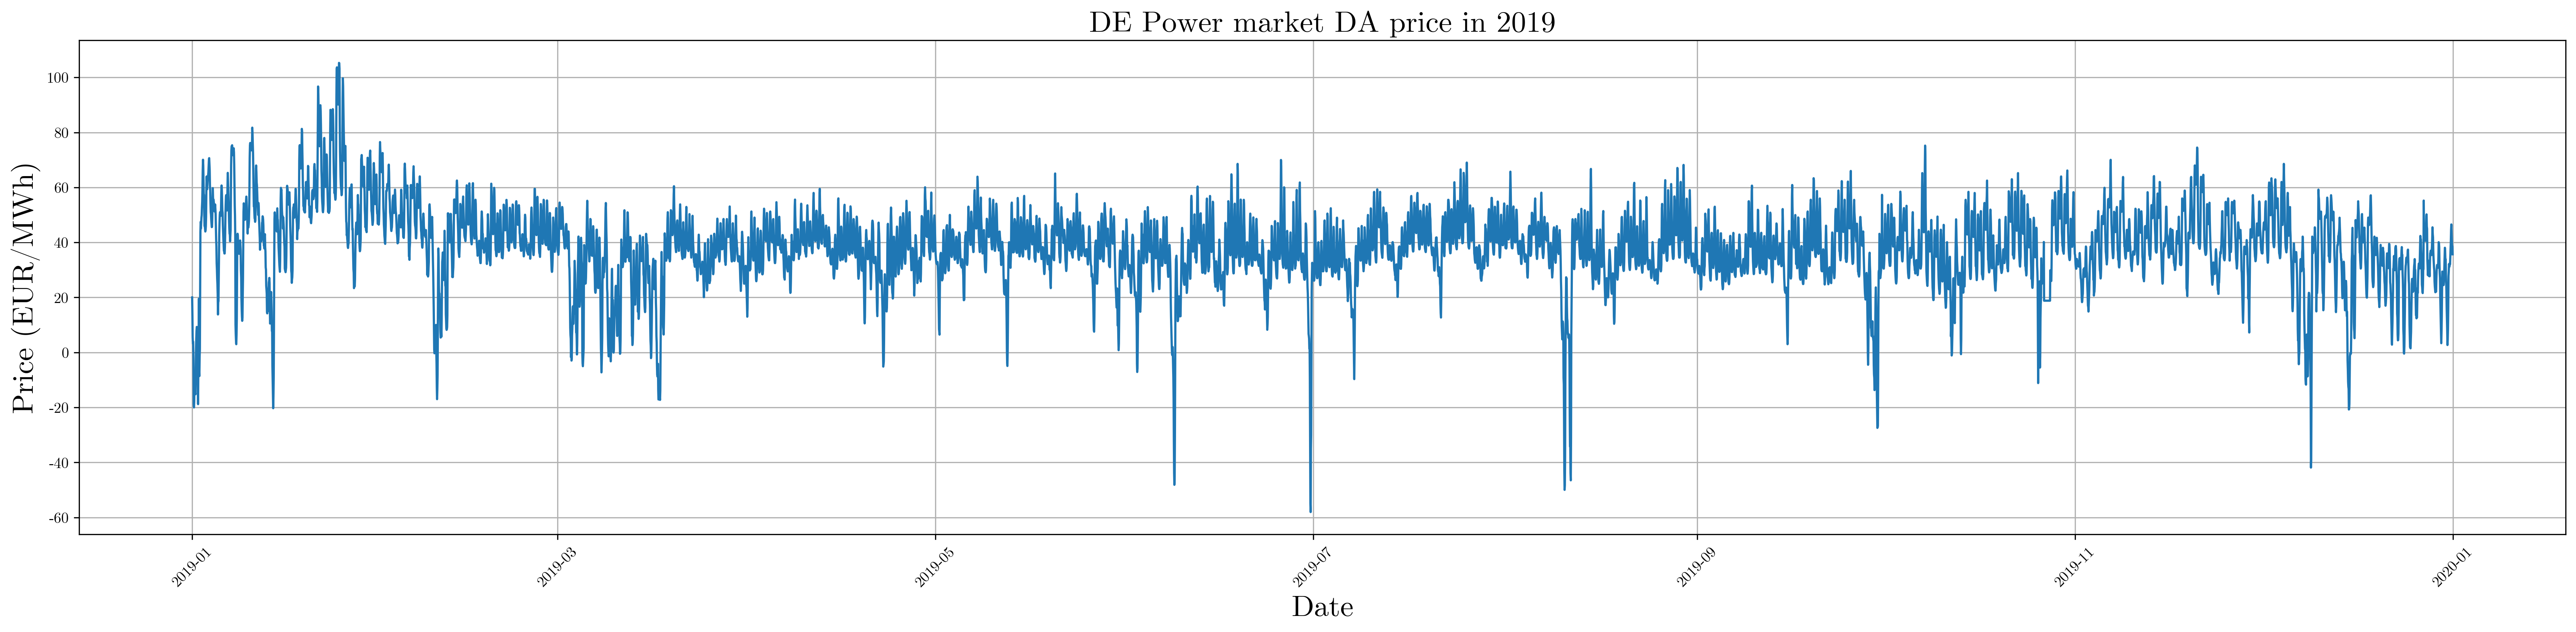

In [5]:

# Plotting
plt.figure(figsize=(30, 6),dpi=300)
plt.plot(df_prices['Timestamp'] ,df_prices['Day-ahead Price [EUR/MWh]'], marker='', linestyle='-')
plt.title(f'DE Power market DA price in 2019',fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Price (EUR/MWh)', fontsize=20)
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig("pricechart.png")
plt.show()

## Solar

In [6]:
df_solar = pd.read_csv("solar.csv")
df_solar.head()

,time,local_time,electricity
0,1/1/2019 0:00,1/1/2019 1:00,0.0
1,1/1/2019 1:00,1/1/2019 2:00,0.0
2,1/1/2019 2:00,1/1/2019 3:00,0.0
3,1/1/2019 3:00,1/1/2019 4:00,0.0
4,1/1/2019 4:00,1/1/2019 5:00,0.0


# Final parameters

In [7]:
df_prices

,Timestamp,Day-ahead Price [EUR/MWh]
0,2019-01-01 00:00:00,20.0025
1,2019-01-01 01:00:00,13.5400
2,2019-01-01 02:00:00,5.5925
3,2019-01-01 03:00:00,3.2000
4,2019-01-01 04:00:00,3.8975
...,...,...
8755,2019-12-31 19:00:00,43.1625
8756,2019-12-31 20:00:00,40.5000
8757,2019-12-31 21:00:00,38.5000
8758,2019-12-31 22:00:00,38.5975


In [8]:
df_demand = filtered_df
df_demand.head()

,UTC,DE TIME,kWh,0.045,Power Change (kWh),Date
19141,2018-01-01 00:00:00+00:00,2018-01-01T01:00:00+0100,5975.186,5975.412,0.265,2018-01-01
19142,2018-01-01 01:00:00+00:00,2018-01-01T02:00:00+0100,5975.412,5975.591,0.226,2018-01-01
19143,2018-01-01 02:00:00+00:00,2018-01-01T03:00:00+0100,5975.591,5975.752,0.179,2018-01-01
19144,2018-01-01 03:00:00+00:00,2018-01-01T04:00:00+0100,5975.752,5975.981,0.161,2018-01-01
19145,2018-01-01 04:00:00+00:00,2018-01-01T05:00:00+0100,5975.981,5976.211,0.229,2018-01-01


In [9]:
N = 456
np.sum(np.array(df_demand["Power Change (kWh)"][N:N+24]))

7.578000000000429

In [10]:
df_solar.head()

,time,local_time,electricity
0,1/1/2019 0:00,1/1/2019 1:00,0.0
1,1/1/2019 1:00,1/1/2019 2:00,0.0
2,1/1/2019 2:00,1/1/2019 3:00,0.0
3,1/1/2019 3:00,1/1/2019 4:00,0.0
4,1/1/2019 4:00,1/1/2019 5:00,0.0


In [11]:
len(df_demand)

8761

# Running the RH Algorithm

In [12]:
from gurobipy import Model, GRB, quicksum
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

# Deterministic optimisation

In [13]:
def det_optimisation(inter_mg_limit, spread, charge_limit, trade_cost, demand_subset, PVgen_subset, price_subset,
                        num_periods, currentSOC,max_capacity, outputflag):
    
    demand = demand_subset
    PVgen = PVgen_subset
    main_grid_prices = price_subset

    # Create a new model
    model = Model("EnergyModel")

    model.setParam('OutputFlag', outputflag)

    
    #Energy purchased from the main grid for each MG in each time period
    Emb = model.addVars(num_consumers, num_periods, name="EM_{i,b}^t", lb=0, vtype=GRB.CONTINUOUS)
    
    #Energy sold to the main grid for each MG in each time period
    Ems = model.addVars(num_consumers, num_periods, name="EM_{i,s}^t", lb=0, vtype=GRB.CONTINUOUS)
    
    #BESS energy stored for each MG iat the end of each time period
    SOC = model.addVars(num_consumers, num_periods, name="EB_{i} ^t", vtype=GRB.CONTINUOUS)


    #Binary variable deciding if BESS is charged for each MG in each time period
    Yc = model.addVars(num_consumers, num_periods, name="Y_{i,C} ^t", vtype=GRB.BINARY)

    #Binary variable deciding if BESS is discharged for each MG in each time period
    Yd = model.addVars(num_consumers, num_periods, name="Y_{i,D} ^t", vtype=GRB.BINARY)
    
    
    #Energy retrieved from battery for each MG in each time period
    Ebc = model.addVars(num_consumers, num_periods, name="EB_{i,C} ^t", lb=0, vtype=GRB.CONTINUOUS)
    Ebd = model.addVars(num_consumers, num_periods, name="EB_{i,D} ^t", lb=0, vtype=GRB.CONTINUOUS)
    

    #Energy retrieved from battery for each MG in each time period
    Emg = model.addVars(num_consumers, num_consumers, num_periods, name="Emg",lb=-2.75e8, vtype=GRB.CONTINUOUS)
    EMGi = model.addVars(num_consumers,num_periods, lb=-2.75e8, name="EMGi", vtype=GRB.CONTINUOUS)
    
    #Cost of MG at time t 
    C = model.addVars(num_consumers, num_periods, name="C", lb=-1e12, vtype=GRB.CONTINUOUS)

    #CONSTRAINTS


    #Basic demand constraint
    for i in range(num_consumers):
        for t in range(num_periods):
            model.addConstr( 0 <= - demand[i, t]+  Emb[i, t] - Ems[i,t] + PVgen[i, t] + Ebd[i, t] - Ebc[i,t]  + EMGi[i,t])
    for i in range(num_consumers):
        #ENd SOC must be initial SOC
        model.addConstr(SOC[i, num_periods-1] >= currentSOC[i] )   
        for t in range(1, num_periods):
        #SOC updating
            model.addConstr(SOC[i, t] == SOC[i, t-1] + (eta*Ebc[i,t] - (1/eta)*Ebd[i,t]))

    for i in range(num_consumers):
        #Charge/Discharge equation for first time step
        model.addConstr(SOC[i, 0] == currentSOC[i] + (eta*Ebc[i,0] - (1/eta)*Ebd[i,0]), name=f"BS1_{i}")
        for t in range(num_periods):
            #Charge/discharge limit
        
            model.addConstr(charge_limit*max_capacity[i]*Yc[i,t] >=  Ebc[i, t])
            model.addConstr(charge_limit*max_capacity[i]*Yd[i,t] >=  Ebd[i, t])
            model.addConstr(Yc[i,t] + Yd[i,t] == 1)
            #Minimum SOC level is 10% of initial
            model.addConstr(SOC[i, t] >= 0.1*max_capacity[i] )
            model.addConstr(SOC[i, t] <= 1.0*max_capacity[i] )

    # Energy trading between MG
    for i in range(num_consumers):
        for j in range(num_consumers):
            for t in range(0, num_periods):
                #energy traded from i to j is net energy, so is negative of j to i
                model.addConstr(Emg[i,j,t] == -Emg[j,i,t])
                #energy traded from i to i is 0
                model.addConstr(Emg[i,i,t] == 0)
                #energy traded from i to j is constrained by max value
                model.addConstr(Emg[i,j,t] <= inter_mg_limit, name=f"inter_{i}_{j}_{t}")
                model.addConstr(Emg[i,j,t] >= -inter_mg_limit)

    for i in range(num_consumers):
        for t in range(num_periods):
             model.addConstr(EMGi[i,t] == quicksum(Emg[i,j,t] for j in range(num_consumers) ))

    for i in range(num_consumers):
        for t in range(num_periods):
            #Sale volume limit
             model.addConstr(Ems[i,t] <= demand[i,t]*1)

    for i in range(num_consumers):
        for t in range(num_periods):
            #Purchase volume limit
             model.addConstr(Emb[i,t] <= demand[i,t]*2)

    if trade_cost is True:
        #Cost of operation of MG:
        for i in range(num_consumers):
            for t in range(num_periods):
                    model.addConstr(C[i,t] == Emb[i, t] * (1.00 + spread) *main_grid_prices[t] - Ems[i, t] * (1-spread) *main_grid_prices[t] + 
                                     EMGi[i,t] * main_grid_prices[t] , name=f"bruh{i}{t}")
    else:
         #Cost of operation of MG - ignore this bit, personal analysis:
        for i in range(num_consumers):
            for t in range(num_periods):
                    model.addConstr(C[i,t] == Emb[i, t] * (1.00 + spread) *main_grid_prices[t] - Ems[i, t] * (1-spread) *main_grid_prices[t]  , name=f"bruh{i}{t}")

    #Same weighting for all MGs, global minimum cost required
    a = np.array([1,1,1,1])
    obj = quicksum(a[i]*C[i,t] for i in range(num_consumers) for t in range(num_periods)) 
    
    # Set the objective
    model.setObjective(obj, GRB.MINIMIZE)

    # Solve the model
    model.optimize()
    
    con = model.getConstrByName('inter_1_0_0')


    
    
    total_sold = sum(Ems[i,t].X for i in range(num_consumers) for t in range(num_periods))
    # print(total_sold)
    
    total_battery = Emg[0,1,0].X
    total_cost = sum(C[i,t].X for i in range(num_consumers) for t in range(num_periods))
    current_cost = sum(C[i,0].X for i in range(num_consumers))
    current_SOC = [[SOC[i,j].X for i in range(num_consumers)] for j in range(num_periods)]
    cost_list = [[C[i,j].X for i in range(num_consumers)] for j in range(num_periods)]
    #print(total_sold)
    return total_sold, total_cost, total_battery, current_cost, current_SOC, cost_list, model


## Converting dataframes into parameter sets

### Deciding on the number of consumers and number of periods/hours (length of parameter set)

In [14]:
num_consumers = 3
num_periods = 8760


### Deciding on the number of houses/units in each MG

In [15]:

# Number of houses/units in each of the three microgrids
number_of_homes = np.array([200, 600, 1900])


### Creating demand parameter set

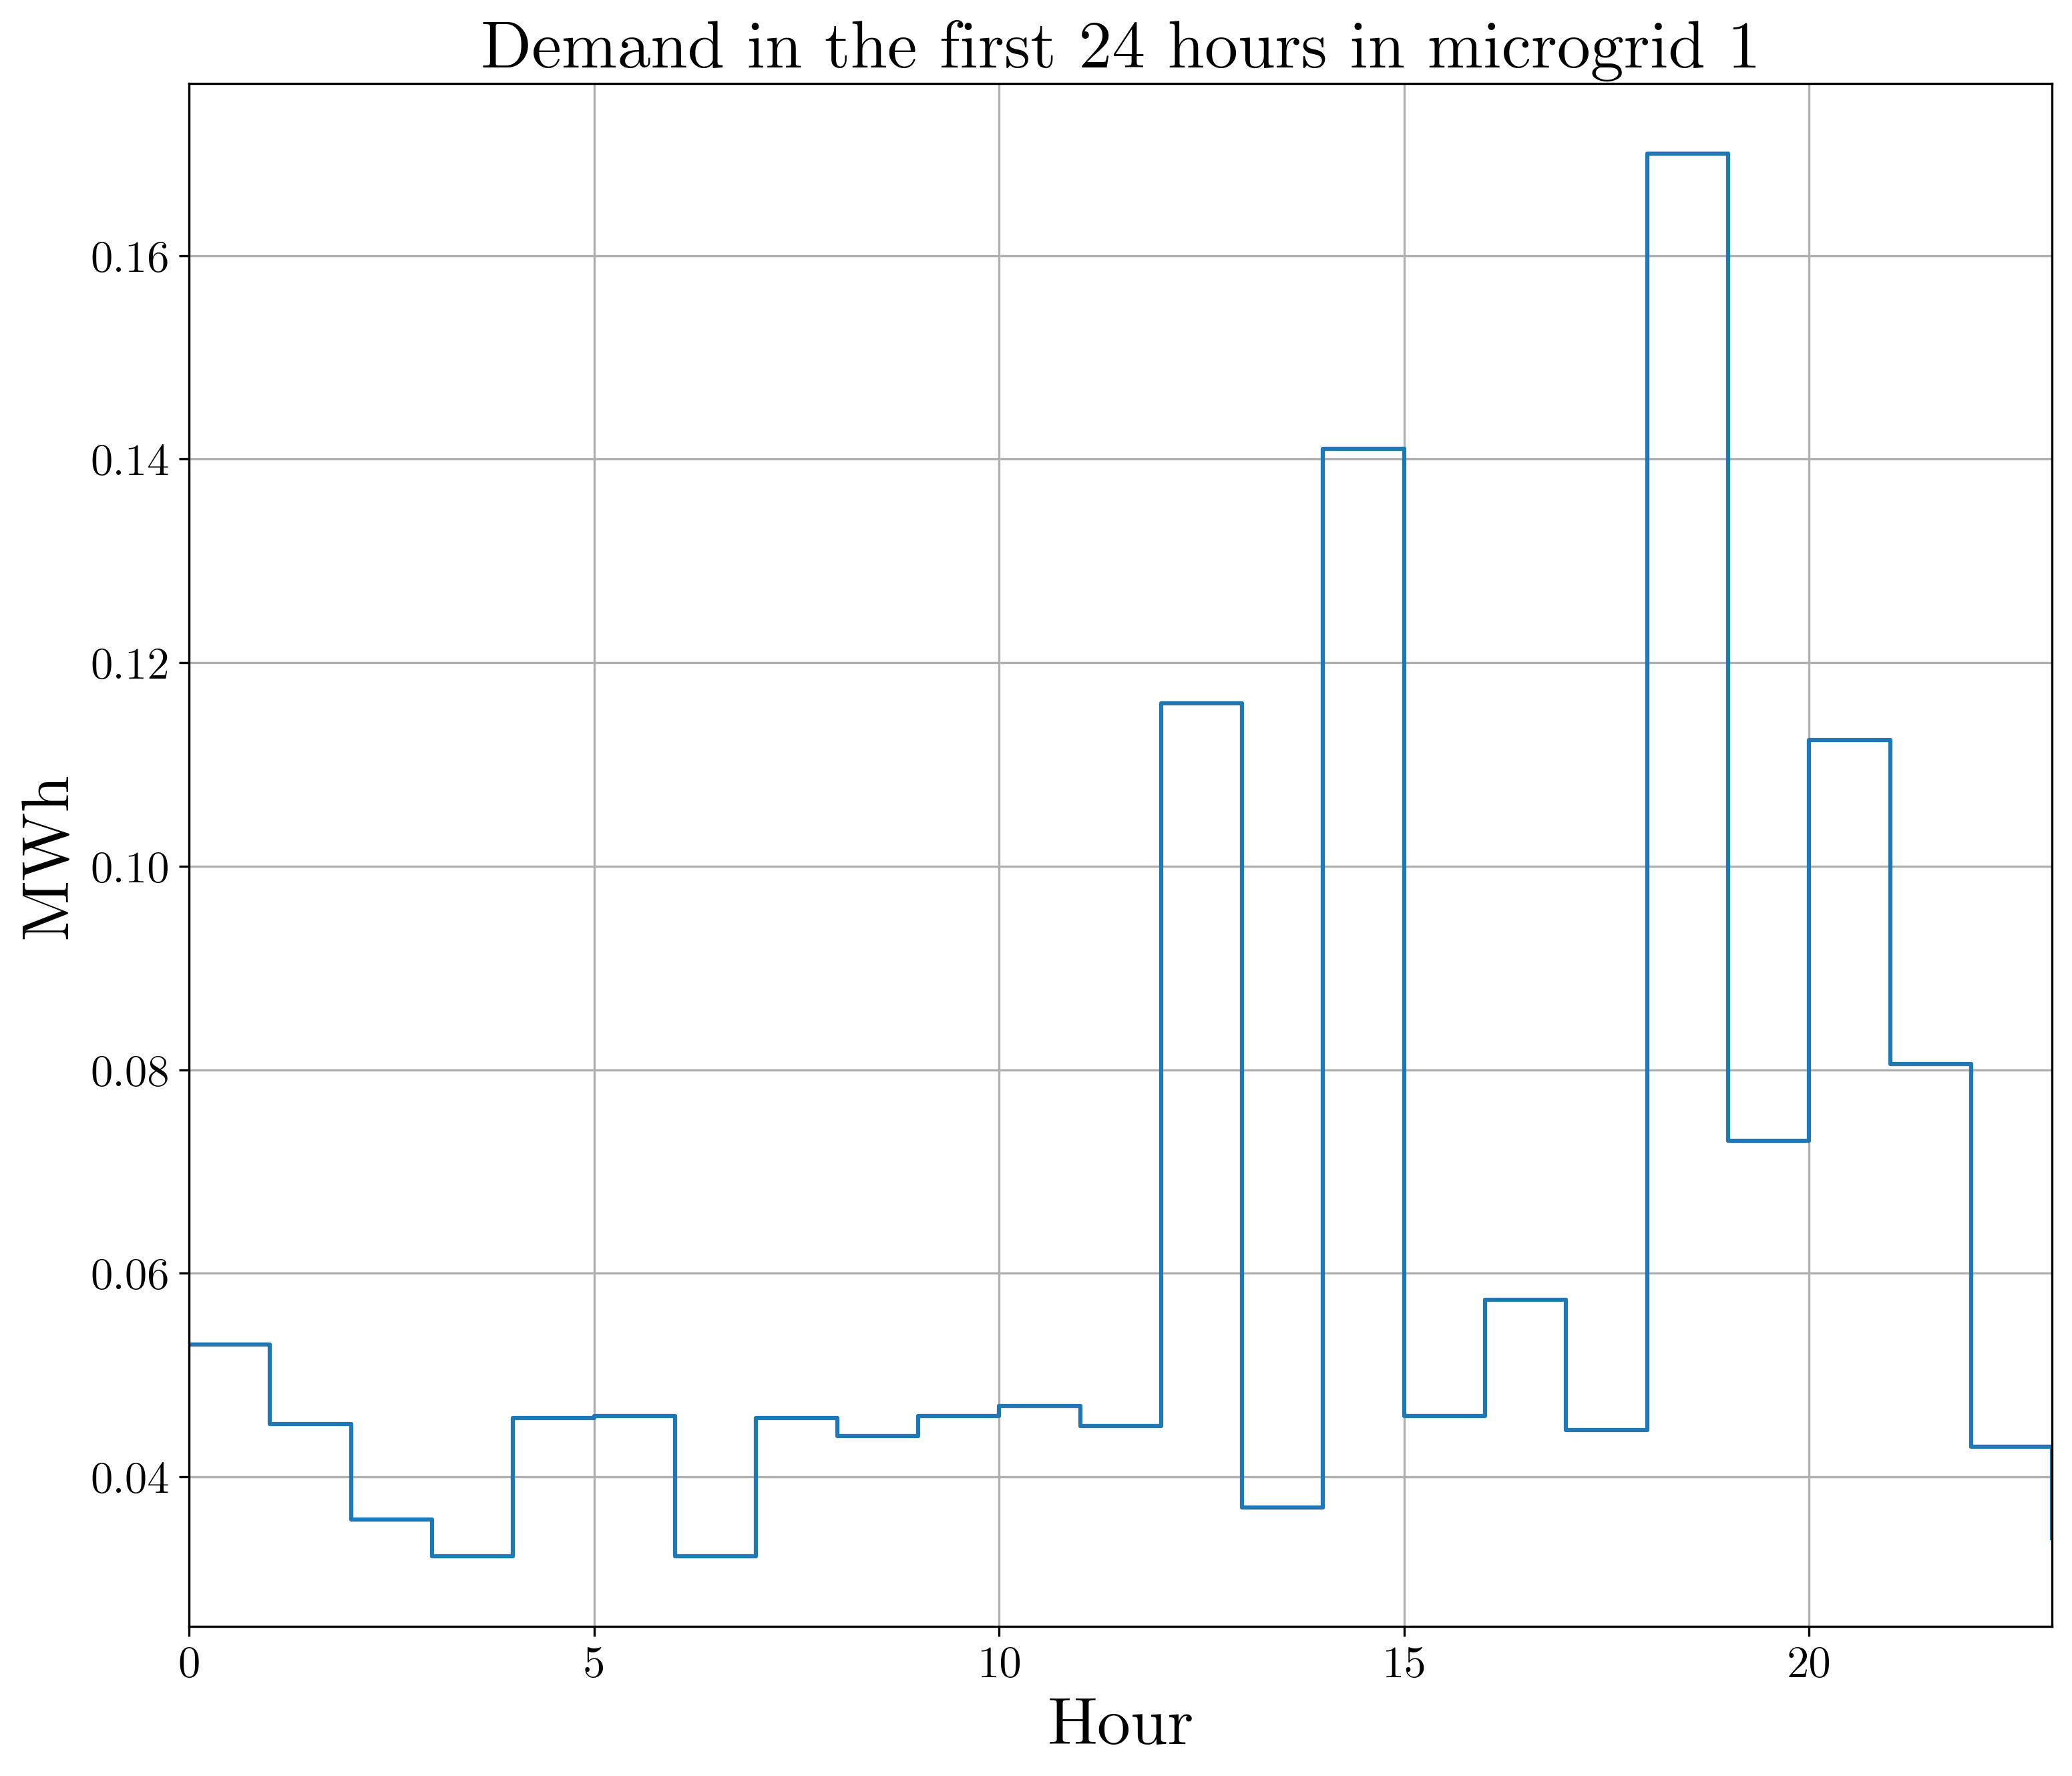

In [16]:
# Convert sets to float to avoid type casting issues
demand_set = np.array(df_demand["Power Change (kWh)"].astype(float))
demand_values = demand_set/1000
demand_list = demand_values * number_of_homes[:, np.newaxis]
demand_list.shape
# Plotting the array
plt.figure(figsize=(12,10), dpi=300)
plt.plot(demand_list[0,:24], marker=' ', drawstyle="steps-post")  # 'o' creates a circle marker at each data point
plt.title('Demand in the first 24 hours in microgrid 1', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.xlabel('Hour' , fontsize=24)
plt.xlim([0,23])
plt.ylabel('MWh' , fontsize=24)
plt.grid(True)  # Adds a grid for easier visualization
plt.savefig("demand_example.png")
plt.show()

### Creating PV production parameter set

In [17]:
# Average solar panel capacity per house in each microgrid in kW
PVavg = {1: 1, 2: 2, 3: 0.9}
solar_irradiance_values = np.array(df_solar.electricity.astype(float))

# Initialize the PV generation array
PV_list = np.zeros((num_consumers, num_periods))

# Calculate PV generation for each consumer and time period
for i in range(num_consumers):
    for t in range(num_periods):
        PV_list[i, t] = solar_irradiance_values[t] * PVavg[i+1] * number_of_homes[i]/1000  # i+1 because dictionary keys start at 1
        
# PVgen is now populated with the PV generation values in MWh for each consumer and time period
PV_list[1,]

len(PV_list[1,])

8760

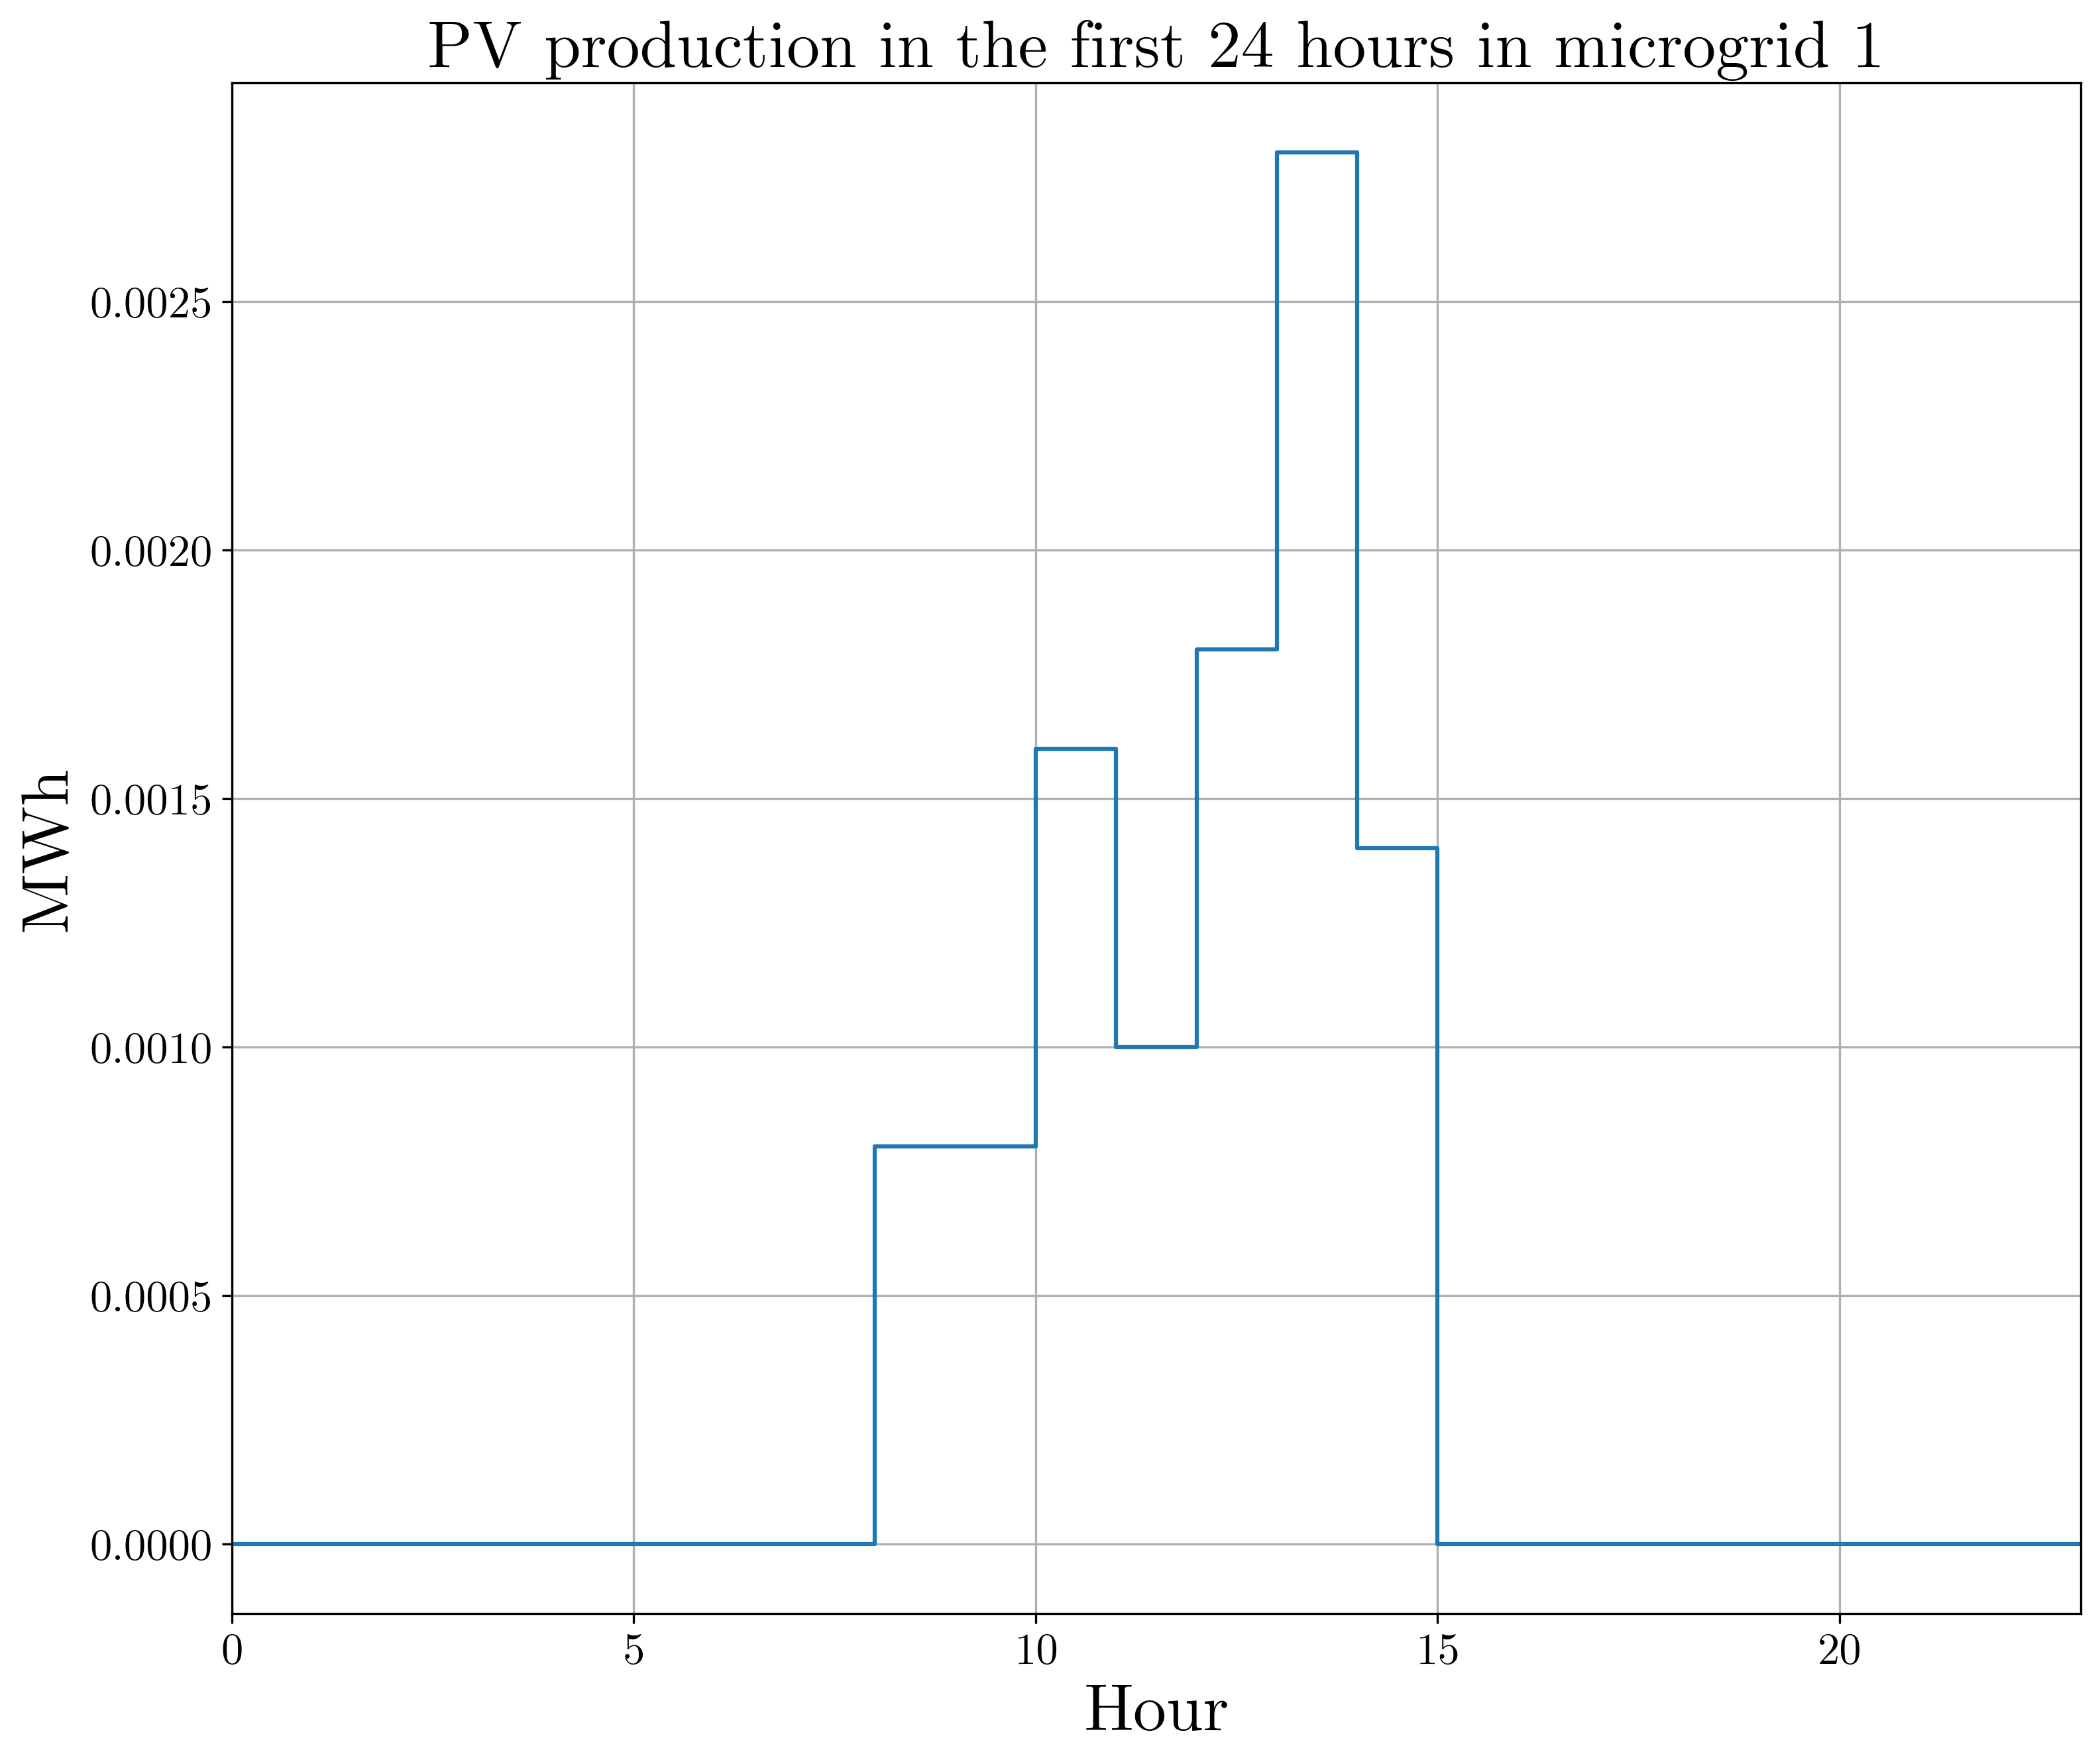

In [18]:
# Plotting the array
plt.figure(figsize=(12,10), dpi=300)
plt.plot(PV_list[0,:24], marker=' ', drawstyle="steps-post")  # 'o' creates a circle marker at each data point
plt.title('PV production in the first 24 hours in microgrid 1', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.xlabel('Hour' , fontsize=24)
plt.xlim([0,23])
plt.savefig("PV_example.png")
plt.ylabel('MWh' , fontsize=24)
plt.grid(True)  # Adds a grid for easier visualization
plt.show()

In [19]:
SOCinitial = []
for i in range(num_consumers):
     SOCinitial.append(PVavg[i+1]*1*number_of_homes[i]*1e-3)
print(SOCinitial)

[0.2, 1.2, 1.71]


In [20]:
df_prices

,Timestamp,Day-ahead Price [EUR/MWh]
0,2019-01-01 00:00:00,20.0025
1,2019-01-01 01:00:00,13.5400
2,2019-01-01 02:00:00,5.5925
3,2019-01-01 03:00:00,3.2000
4,2019-01-01 04:00:00,3.8975
...,...,...
8755,2019-12-31 19:00:00,43.1625
8756,2019-12-31 20:00:00,40.5000
8757,2019-12-31 21:00:00,38.5000
8758,2019-12-31 22:00:00,38.5975


In [21]:
SOCinitial = []
for i in range(num_consumers):
     SOCinitial.append(PVavg[i+1]*1*number_of_homes[i]*1e-3)
print(SOCinitial)

[0.2, 1.2, 1.71]


# Testing algorithm

[0.3, 1.8, 2.565]
Printing determinstic/RH cost ratio
0.032398434258693806
786.2222305059149
deterministic cost
23481.068720288717
RH cost
24267.29095079463


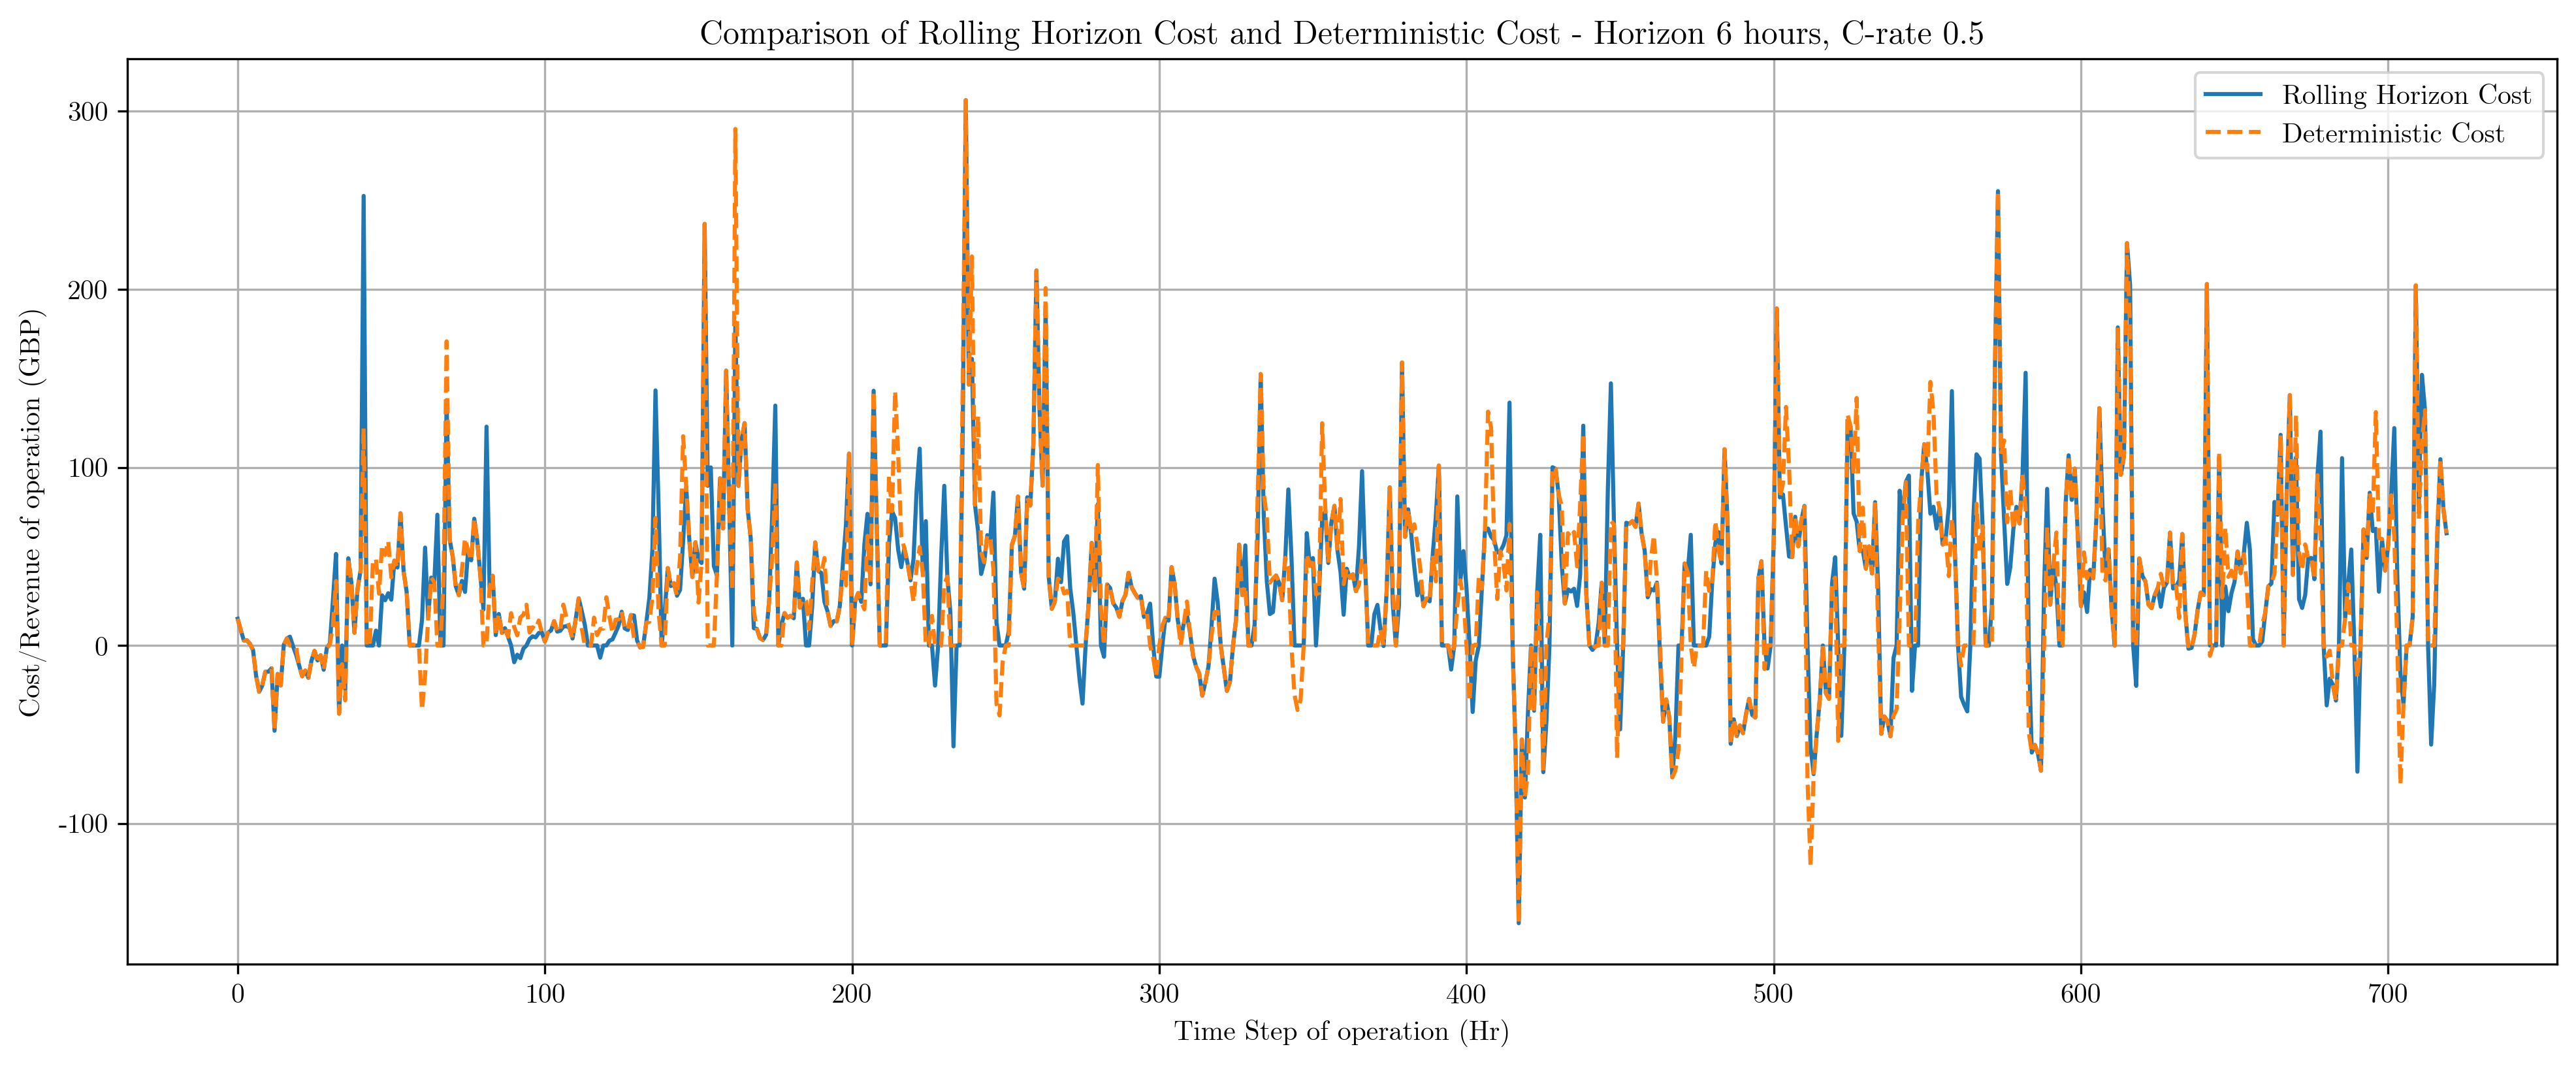

In [23]:
price_set = np.array(df_prices["Day-ahead Price [EUR/MWh]"].astype(float))
#price_set = np.where(price_set < 0, 5, price_set)
np.random.seed(42)
SOCinitial = []
for i in range(num_consumers):
     SOCinitial.append(PVavg[i+1]*1.5*number_of_homes[i]*1e-3)
print(SOCinitial)

max_capacity = np.array(SOCinitial)

current_SOC = max_capacity*0.1

num_consumers = 3



mybruh=False

# Initialize variables
total_rolling_horizon_cost = 0
rolling_horizon_costs = []  # To store costs from each iteration
#24 hours times 10 days
simulation_duration = 24*30
horizon_length = 6 # Planning horizon length

inter_microgrid_limit = 1 # Inter-microgrid trading limit

price_spread = 0.05  # Price spread for trades
charging_limit = 0.5  # Battery charging limit
is_trade_cost_enabled = True  # Flag for enabling trade costs
sigma = 0.0  #Price/Demand/PV uncertainty
eta = 0.95

# Convert sets to float to avoid type casting issues
demand_set = demand_list.astype(float)
PV_generation_set = PV_list.astype(float)


   
      
for hour in range(simulation_duration):
    # Determine the end of the planning horizon within the simulation bounds
    horizon_end = min(hour + horizon_length, simulation_duration)

    demand_subset = np.array(demand_set[:, hour:horizon_end])

    PV_generation_subset = PV_generation_set[:, hour:horizon_end]

    
    price_subset = price_set[hour:horizon_end]

    

    try:
        total_sold, total_cost, total_battery_usage, current_cost, updated_SOC, cost_list, model = det_optimisation(
            inter_microgrid_limit, price_spread, charging_limit, is_trade_cost_enabled,
            demand_subset, PV_generation_subset, price_subset, horizon_end - hour, current_SOC, max_capacity, outputflag=0)
    except:
        print(hour)
        print(demand_subset)
        print(PV_generation_subset)
        print(price_subset)
        PV_generation_subset[:] = 0.01
        print(current_SOC)
        print(initial_SOC)
        total_sold, total_cost, total_battery_usage, current_cost, updated_SOC, cost_list = det_optimisation(
            inter_microgrid_limit, price_spread, charging_limit, is_trade_cost_enabled,
            demand_subset, PV_generation_subset, price_subset, horizon_end - hour, current_SOC, max_capacity, outputflag=1)
    # Update costs and SOC for the next iteration
    rolling_horizon_costs.append(current_cost)
    total_rolling_horizon_cost += current_cost
    current_SOC = updated_SOC[0]  # Assuming updated_SOC is an array of SOC values

# Final aggregation and analysis over the entire simulation period
final_demand_subset = demand_set[:, :simulation_duration]
final_PV_generation_subset = PV_generation_set[:, :simulation_duration]
final_price_subset = price_set[:simulation_duration]

# Run the final robust optimization for the entire simulation period
total_sold, total_cost, total_battery_usage, final_cost, final_SOC , cost_list, model = det_optimisation(
    inter_microgrid_limit, price_spread, charging_limit, is_trade_cost_enabled,
    final_demand_subset, final_PV_generation_subset, final_price_subset, simulation_duration, current_SOC, max_capacity, outputflag=0)

# Calculate and print the cost comparison
print("Printing determinstic/RH cost ratio")
print(( np.sum(np.array(rolling_horizon_costs)[:simulation_duration]) - total_cost) / np.sum(np.array(rolling_horizon_costs)[:simulation_duration]))
print( np.sum(np.array(rolling_horizon_costs)[:simulation_duration]) - total_cost)
print("deterministic cost")
print(total_cost)
print("RH cost")
print(np.sum(np.array(rolling_horizon_costs)[:simulation_duration]))


total_deterministic_costs = [sum(sublist) for sublist in cost_list]

# Setting figure size
plt.figure(figsize=(16, 6), dpi=300)  # Adjust the values (width, height) as needed


# Plotting
plt.plot(rolling_horizon_costs, label='Rolling Horizon Cost', marker='None', linestyle='-')
plt.plot(total_deterministic_costs, label='Deterministic Cost', marker='None', linestyle='--')


plt.xlabel('Time Step of operation (Hr)')
plt.ylabel('Cost/Revenue of operation (GBP)')
plt.title(f'Comparison of Rolling Horizon Cost and Deterministic Cost - Horizon {horizon_length} hours, C-rate {charging_limit}')
plt.legend()
plt.grid(True)
plt.savefig(f'Comparison of Rolling Horizon Cost and Deterministic Cost - Horizon {horizon_length} hours, C-rate {charging_limit}.png')
plt.show()

## Testing only deterministic optimal policy generation

In [102]:

# Constants
NUM_CONSUMERS = 3
SIMULATION_DURATION = 24*30*12
HORIZON_LENGTH = 12  # Planning horizon length in hours
INTER_MICROGRID_LIMIT = 0.1  # Inter-microgrid trading limit
PRICE_SPREAD = 0.05  # Price spread for trades
CHARGING_LIMIT = 0.1 # Battery charging limit
TRADE_COST_ENABLED = True  # Flag for enabling trade costs
UNCERTAINTY_SIGMA = 0.0  # Price/Demand/PV uncertainty
CHARGING_EFFICIENCY = 0.95  # Charging efficiency
eta=CHARGING_EFFICIENCY
SEED = 42  # Seed for random number generator

# Initialize random seed
np.random.seed(SEED)

# Data initialization
price_set = np.array(df_prices["Day-ahead Price [EUR/MWh]"].astype(float))
# Uncomment the next line if you want to replace negative prices with 5 EUR/MWh
# price_set = np.where(price_set < 0, 5, price_set)

# Initialize State of Charge (SOC)
max_capacity = np.array([PVavg[i + 1] * number_of_homes[i] * 1e-3 * 1.5 for i in range(NUM_CONSUMERS)])
current_SOC = max_capacity*0.1

print("Initial SOC:", current_SOC)
print("Max capacity:", max_capacity)

# Initialize simulation variables
total_rolling_horizon_cost = 0
rolling_horizon_costs = []

# Convert arrays to float to avoid typecasting issues later
demand_set = demand_list.astype(float)
PV_generation_set = PV_list.astype(float)




# Data initialization
price_set = np.array(df_prices["Day-ahead Price [EUR/MWh]"].astype(float))
# Convert arrays to float to avoid typecasting issues later
demand_set = demand_list.astype(float)
PV_generation_set = PV_list.astype(float)

# Initialize State of Charge (SOC)
max_capacity = np.array([PVavg[i + 1] * number_of_homes[i] * 1e-3 * 1.5 for i in range(NUM_CONSUMERS)])
current_SOC = max_capacity*0.1



# Final aggregation and analysis
final_demand_subset = demand_set[:, :SIMULATION_DURATION]
final_PV_generation_subset = PV_generation_set[:, :SIMULATION_DURATION]
final_price_subset = price_set[:SIMULATION_DURATION]







Initial SOC: [0.03   0.18   0.2565]
Max capacity: [0.3   1.8   2.565]


In [103]:
def det_optimisation(inter_mg_limit, spread, charge_limit, trade_cost, demand_subset, PVgen_subset, price_subset,
                        num_periods, currentSOC,max_capacity, outputflag):
    
    demand = demand_set
    PVgen = PV_generation_set
    main_grid_prices = price_set

    # Create a new model
    model = Model("EnergyModel")

    model.setParam('OutputFlag', outputflag)

    
    #Energy purchased from the main grid for each MG in each time period
    Emb = model.addVars(num_consumers, num_periods, name="Emb", lb=0, vtype=GRB.CONTINUOUS)
    
    #Energy sold to the main grid for each MG in each time period
    Ems = model.addVars(num_consumers, num_periods, name="Ems", lb=0, vtype=GRB.CONTINUOUS)
    
    #BESS state of charge for each MG in each time period
    SOC = model.addVars(num_consumers, num_periods, name="SOC", vtype=GRB.CONTINUOUS)

    Yc = model.addVars(num_consumers, num_periods, name="Yc", vtype=GRB.BINARY)
    
    Yd = model.addVars(num_consumers, num_periods, name="Yd", vtype=GRB.BINARY)
    
    
    #Energy retrieved from battery for each MG in each time period
    Ebc = model.addVars(num_consumers, num_periods, name="Ebc", lb=0, vtype=GRB.CONTINUOUS)
    Ebd = model.addVars(num_consumers, num_periods, name="Ebd", lb=0, vtype=GRB.CONTINUOUS)
    

    #Energy retrieved from battery for each MG in each time period
    Emg = model.addVars(num_consumers, num_consumers, num_periods, name="Emg",lb=-2.75e8, vtype=GRB.CONTINUOUS)
    EMGi = model.addVars(num_consumers,num_periods, lb=-2.75e8, name="EMGi", vtype=GRB.CONTINUOUS)
    
    #Cost of MG at time t 
    C = model.addVars(num_consumers, num_periods, name="C", lb=-1e12, vtype=GRB.CONTINUOUS)

    #CONSTRAINTS
    for i in range(num_consumers):
        for t in range(num_periods):
            model.addConstr( 0 <= - demand[i, t]+  Emb[i, t] - Ems[i,t] + PVgen[i, t] + Ebd[i, t] - Ebc[i,t]  + sum(Emg[i,j,t] for j in range(num_consumers)))
    for i in range(num_consumers):
        model.addConstr(SOC[i, num_periods-1] >= currentSOC[i] )   
        for t in range(1, num_periods):
        #SOC updating
            model.addConstr(SOC[i, t] == SOC[i, t-1] + (eta*Ebc[i,t] - (1/eta)*Ebd[i,t]))

    # Initial State of Charge
    for i in range(num_consumers):
        model.addConstr(SOC[i, 0] == currentSOC[i] + (eta*Ebc[i,0] - (1/eta)*Ebd[i,0]), name=f"BS1_{i}")
        for t in range(num_periods):
            #Charge/discharge limit
            #model.addConstr( 0 >= - (Yd[i,t]*charge_limit*SOCinitial[i]) + Eb[i, t])
            model.addConstr(charge_limit*max_capacity[i]*Yc[i,t] >=  Ebc[i, t])
            model.addConstr(charge_limit*max_capacity[i]*Yd[i,t] >=  Ebd[i, t])
            
            #Minimum SOC level is 20% of initial
            model.addConstr(SOC[i, t] >= 0.1*max_capacity[i] )
            model.addConstr(SOC[i, t] <= 1.0*max_capacity[i] )

    # Energy trading between MG
    for i in range(num_consumers):
        for j in range(num_consumers):
            for t in range(0, num_periods):
                #energy traded from i to j is net energy, so is negative of j to i
                model.addConstr(Emg[i,j,t] == -Emg[j,i,t])
                #energy traded from i to i is 0
                #model.addConstr(Emg[i,i,t] == 0)
                #energy traded from i to j is constrained by max value
                model.addConstr(Emg[i,j,t] <= inter_mg_limit, name=f"inter_{i}_{j}_{t}")
                model.addConstr(Emg[i,j,t] >= -inter_mg_limit)

    for i in range(num_consumers):
        for t in range(num_periods):
             model.addConstr(EMGi[i,t] == quicksum(Emg[i,j,t] for j in range(num_consumers) ))

    for i in range(num_consumers):
        for t in range(num_periods):
             model.addConstr(Ems[i,t] <= demand[i,t]*1)

    for i in range(num_consumers):
        for t in range(num_periods):
             model.addConstr(Emb[i,t] <= demand[i,t]*1.5)

    if trade_cost is True:
        #Cost of operation of MG:
        for i in range(num_consumers):
            for t in range(num_periods):
                    model.addConstr(C[i,t] == Emb[i, t] * (1.00 + spread) *main_grid_prices[t] - Ems[i, t] * (1-spread) *main_grid_prices[t] + 
                                     EMGi[i,t] * main_grid_prices[t] , name=f"bruh{i}{t}")
    else:
         #Cost of operation of MG:
        for i in range(num_consumers):
            for t in range(num_periods):
                    model.addConstr(C[i,t] == Emb[i, t] * (1.00 + spread) *main_grid_prices[t] - Ems[i, t] * (1-spread) *main_grid_prices[t]  , name=f"bruh{i}{t}")
    
    a = np.array([1,1,1,1])
    obj = quicksum(a[i]*C[i,t] for i in range(num_consumers) for t in range(num_periods)) 
    
    # Set the objective
    model.setObjective(obj, GRB.MINIMIZE)

    # Solve the model
    model.optimize()
    
    con = model.getConstrByName('inter_1_0_0')
    N=1000
    

       
    total_sold = sum(Ems[i,t].X for i in range(num_consumers) for t in range(num_periods))
    # print(total_sold)
    
    total_battery = Emg[0,1,0].X
    total_cost = sum(C[i,t].X for i in range(num_consumers) for t in range(num_periods))
    current_cost = sum(C[i,0].X for i in range(num_consumers))
    current_SOC = [[SOC[i,j].X for i in range(num_consumers)] for j in range(num_periods)]
    cost_list = [[C[i,j].X for i in range(num_consumers)] for j in range(num_periods)]
    #print(total_sold)
    
    
    if mybruh == True:
       
        # Existing y-values (first line)
        y_values = np.array(final_demand_subset[1, :])
        # New y-values for the second line
        y_values2 = model.getAttr('X', Emb).select(1, "*") # Replace this with your actual data
        
        
         # New y-values for the second line
        y_values2 = model.getAttr('X', Emb).select(1, "*") # Replace this with your actual data
        
        # New y-values for the second line
        y_values3 = model.getAttr('X', Ems).select(1, "*")
        
        y_values4 = model.getAttr('X', SOC).select(1, "*") 
        
        y_values5 = final_price_subset[:]/1000
        
        
        y_values7 = model.getAttr('X', EMGi).select(1, "*") 
        
        y_values6 = np.array(PVgen[1, :])
        
        # Corresponding x-values (time periods in hours)
        x_values = np.arange(len(y_values))
        model = [y_values, y_values2, y_values3, y_values4, y_values5, y_values6, y_values7]
        
    return total_sold, total_cost, total_battery, current_cost, current_SOC, cost_list, model

mybruh=True
# Run the final robust optimization for the entire simulation period
total_sold, total_cost, total_battery_usage, final_cost, final_SOC , cost_list, model = det_optimisation(
    inter_microgrid_limit, price_spread, charging_limit, is_trade_cost_enabled,
    final_demand_subset, final_PV_generation_subset, final_price_subset, simulation_duration, current_SOC, max_capacity, outputflag=0)


In [112]:
max(final_demand_subset[1, :])

1.0559999999995853

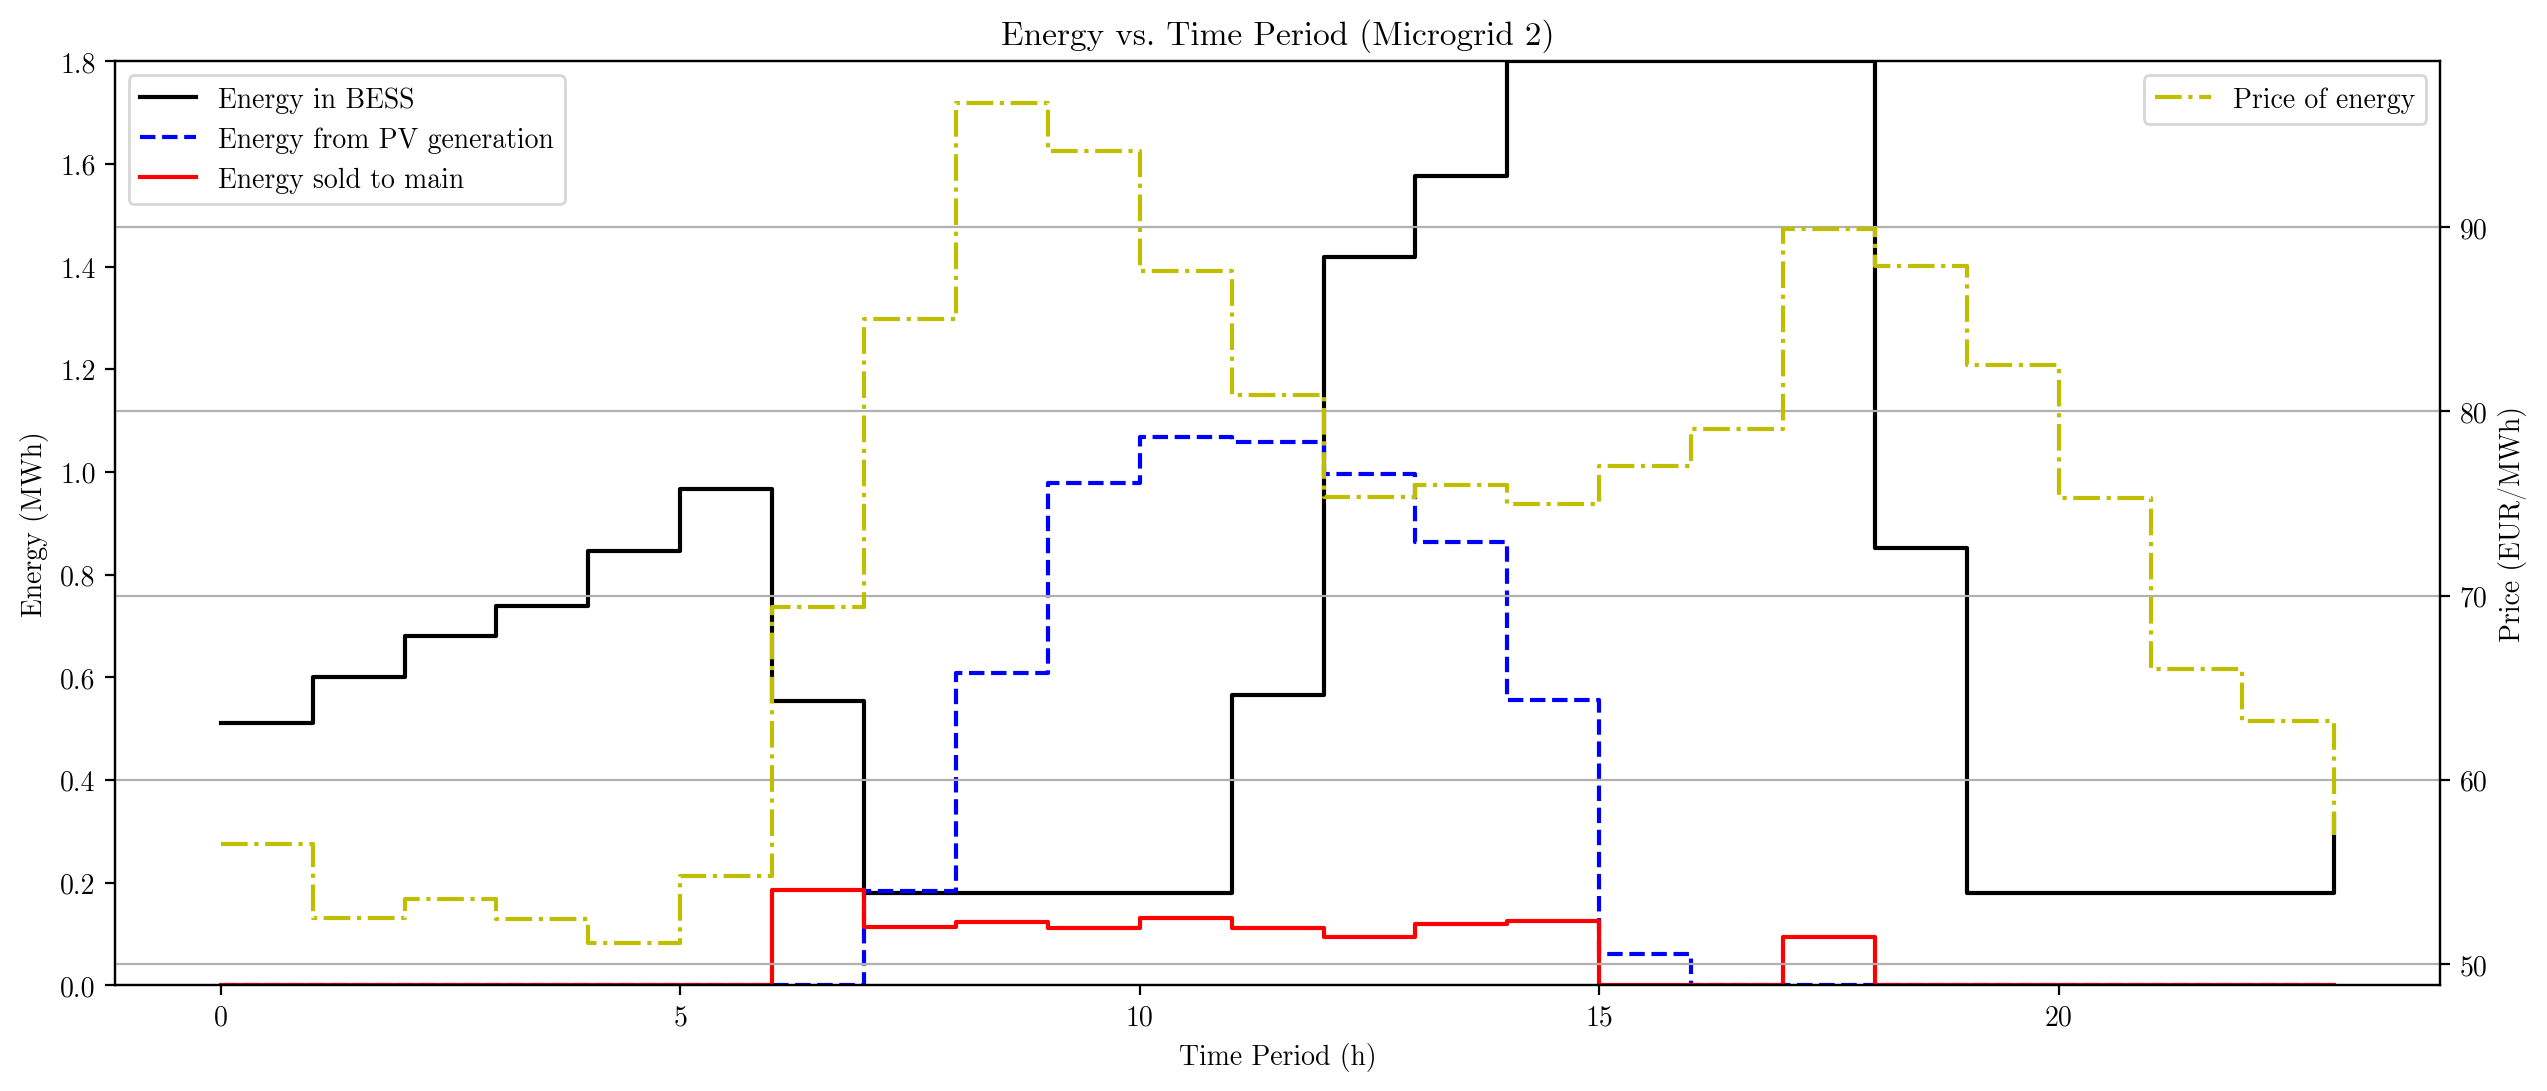

In [124]:

N=24*20
#Demand data
y_values = np.array(final_demand_subset[1, :])
y_values = y_values[N:N+24]


# Energy Bought from grid
y_values2 = model[1]
y_values2 = y_values2[N:N+24]


# Energy sold from grid
y_values3 = model[2]
y_values3 = y_values3[N:N+24]


#Battery charge
y_values4 = model[3]
y_values4 = y_values4[N:N+24]


#Price of energy
y_values5 = final_price_subset[:]
y_values5 = y_values5[N:N+24]

#Energy traded with other grids
y_values7 = model[6]
y_values7 = abs(np.array(y_values7[N:N+24]))


#Energy from PV generation
y_values6 = model[5]
y_values6 = y_values6[N:N+24]

# Corresponding x-values (time periods in hours)
x_values = np.arange(len(y_values))

plt.figure(figsize=(15, 6), dpi=200)


# Creating the first subplot for energy related data
ax1 = plt.gca()  # Get the current Axes instance on the current figure matching the given keyword args, or create one.

ax1.plot(x_values, y_values4, '-', label="Energy in BESS", alpha=1, drawstyle="steps-post", color="black")
ax1.plot(x_values, y_values6, '--', label='Energy from PV generation', alpha=1, drawstyle="steps-post", color="blue")
ax1.plot(x_values, y_values3, '-', label='Energy sold to main', alpha=1, drawstyle="steps-post", color="red")
#ax1.plot(x_values, y_values5, '*-', color='purple', label='SOC', alpha=1, drawstyle="steps-post")
#ax1.plot(x_values, y_values6, '-', label='PV generation', alpha=1, drawstyle="steps-post", color="green")

# Labeling the first y-axis
ax1.set_xlabel('Time Period (h)')
ax1.axis(ymin=0.0,ymax=1.8)
ax1.set_ylabel('Energy (MWh)', color='black')  # You can adjust the color to match your design preferences
ax1.tick_params(axis='y', labelcolor='black')  # Ensuring the tick labels match the line color
ax1.legend(loc='upper left')

# Creating the second subplot for price related data using twinx


ax2 = ax1.twinx()
ax2.plot(x_values, y_values5, '-.', label='Price of energy', color="y", drawstyle="steps-post")
ax2.set_ylabel('Price (EUR/MWh)', color='black')  # Labeling the second y-axis
ax2.tick_params(axis='y', labelcolor='black')  # Ensuring the tick labels match the line color
ax2.legend(loc='upper right')



# Adding titles and grid
plt.title("Energy vs. Time Period (Microgrid 2)")
plt.grid(True)

# Save and show plot
plt.savefig("graphanalysis1.png")
plt.show()

mybruh=False

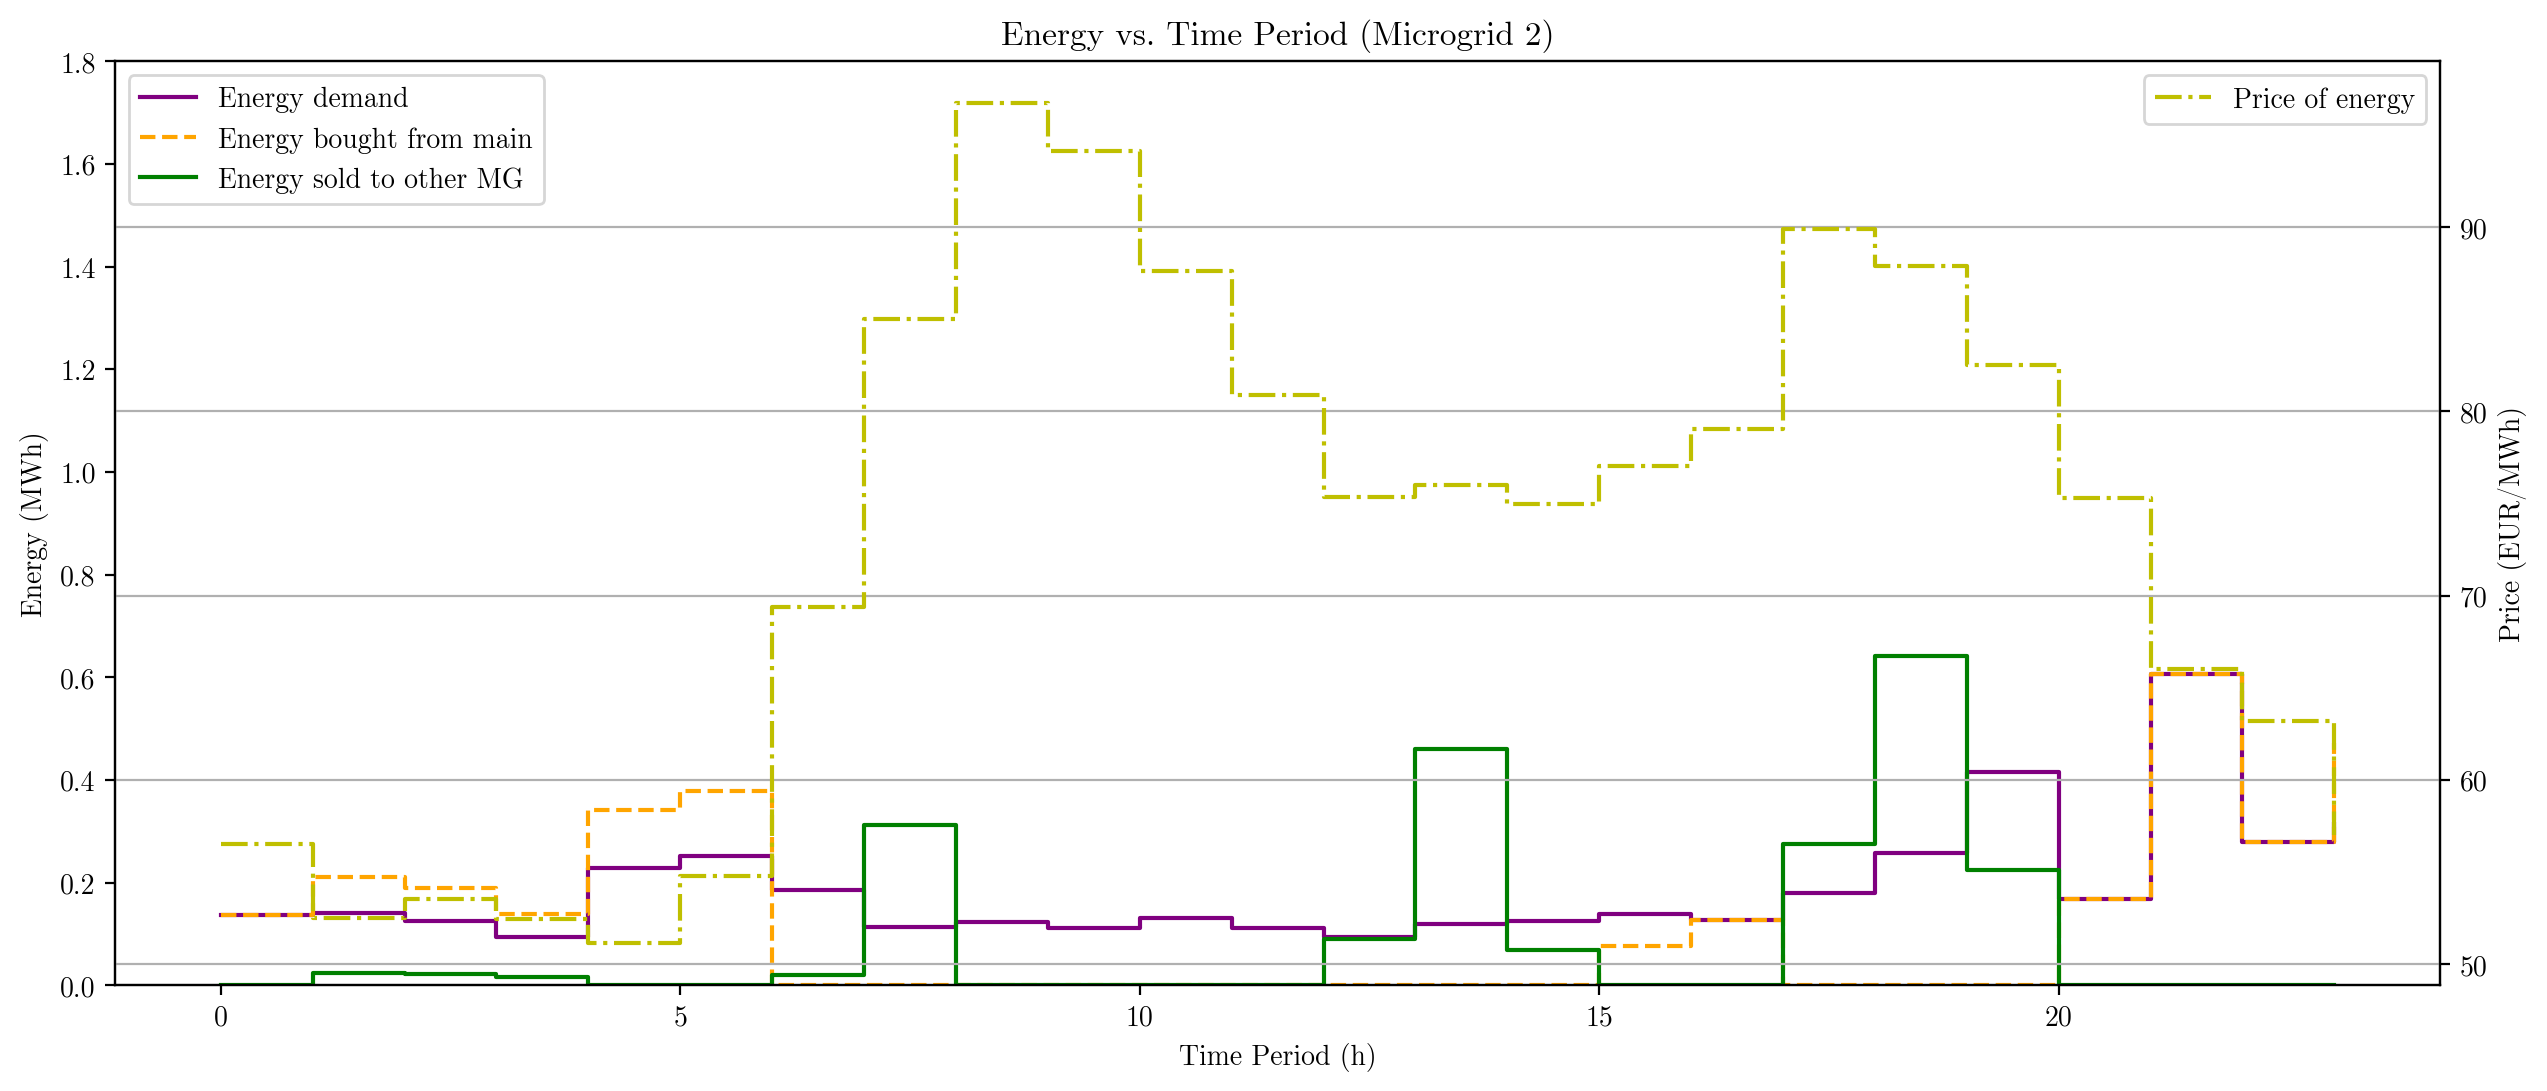

In [125]:



# Corresponding x-values (time periods in hours)
x_values = np.arange(len(y_values))

plt.figure(figsize=(15, 6), dpi=200)


# Creating the first subplot for energy related data
ax1 = plt.gca()  # Get the current Axes instance on the current figure matching the given keyword args, or create one.

ax1.plot(x_values, y_values, '-', label="Energy demand", alpha=1, drawstyle="steps-post", color="purple")
ax1.plot(x_values, y_values2, '--', label='Energy bought from main', alpha=1, drawstyle="steps-post", color="orange")
ax1.plot(x_values, y_values7, '-', label='Energy sold to other MG', alpha=1, drawstyle="steps-post", color="green")
#ax1.plot(x_values, y_values5, '*-', color='purple', label='SOC', alpha=1, drawstyle="steps-post")
#ax1.plot(x_values, y_values6, '-', label='PV generation', alpha=1, drawstyle="steps-post", color="green")

# Labeling the first y-axis
ax1.set_xlabel('Time Period (h)')
ax1.axis(ymin=0.0,ymax=1.8)
ax1.set_ylabel('Energy (MWh)', color='black')  # You can adjust the color to match your design preferences
ax1.tick_params(axis='y', labelcolor='black')  # Ensuring the tick labels match the line color
ax1.legend(loc='upper left')

# Creating the second subplot for price related data using twinx


ax2 = ax1.twinx()
ax2.plot(x_values, y_values5, '-.', label='Price of energy', color="y", drawstyle="steps-post")
ax2.set_ylabel('Price (EUR/MWh)', color='black')  # Labeling the second y-axis
ax2.tick_params(axis='y', labelcolor='black')  # Ensuring the tick labels match the line color
ax2.legend(loc='upper right')



# Adding titles and grid
plt.title("Energy vs. Time Period (Microgrid 2)")
plt.grid(True)

# Save and show plot
plt.savefig("graphanalysis2.png")
plt.show()

mybruh=False